In [1]:
import pennylane as qml
from pennylane import numpy as np
import qemzmsepcV2 as qem

Cost after step     5:  1.1515502
Cost after step    10:  0.3223757
Cost after step    15:  0.1523438
Cost after step    20:  0.1040668
Cost after step    25:  0.0804459
Cost after step    30:  0.0706180
Cost after step    35:  0.0515007
Cost after step    40:  0.0377025
Cost after step    45:  0.0319623
Cost after step    50:  0.1003997
Cost after step    55:  0.0515805
Cost after step    60:  0.0933057
Cost after step    65:  0.0225992
Cost after step    70:  0.0927733
Cost after step    75:  0.1037954
Cost after step    80:  0.0994681
Cost after step    85:  0.0827085
Cost after step    90:  0.0994775
Cost after step    95:  0.0658880
Cost after step   100:  0.0545379
Optimized rotation angles: [[[ 0.45621144  1.49547785  0.03204644]
  [ 0.21146421  0.95301983  0.08796442]]

 [[-0.08150395  2.18819523  0.26552085]
  [ 0.89127828  0.44993722  0.15082301]]]


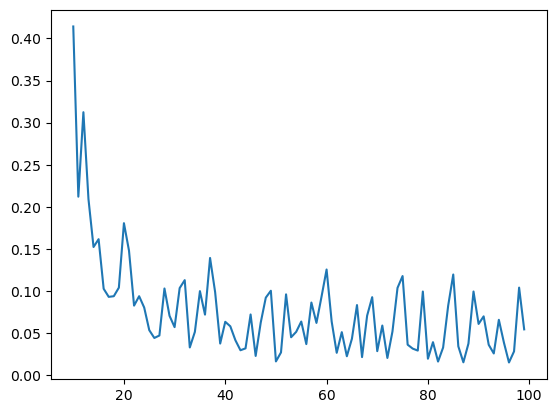

In [2]:
# we introduced noise into the network and trained it without any error mitigation techniques
# to observe the behavior of the Loss function degradation during training.

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
p = 0.9

qemzmsepc = qem.QEMZMSEPC(n_qubits)

def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    return (qml.QNode(qemzmsepc.noise_circuit, dev)(train_cir_without_qem, x, p=p,
            kraus_matrices_of_a_pauli_channel=nqubitspaulichannel,
            need_gate_noise=True, need_measurement_noise=True) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

# When simulating a complex scenario of time-varying noise channels,
# it can be observed that the descent of the Loss function is relatively unstable
# in the absence of error mitigation techniques.

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

Cost after step     5:  0.4204229
Cost after step    10:  0.1060648
Cost after step    15:  0.0480682
Cost after step    20:  0.0282395
Cost after step    25:  0.0190303
Cost after step    30:  0.0139360
Cost after step    35:  0.0107843
Cost after step    40:  0.0086775
Cost after step    45:  0.0071873
Cost after step    50:  0.0060871
Cost after step    55:  0.0052469
Cost after step    60:  0.0045878
Cost after step    65:  0.0040590
Cost after step    70:  0.0036268
Cost after step    75:  0.0032681
Cost after step    80:  0.0029662
Cost after step    85:  0.0027093
Cost after step    90:  0.0024883
Cost after step    95:  0.0022965
Cost after step   100:  0.0021288
Optimized rotation angles: [[[0.88353747 1.0086326  0.23583899]
  [0.63678432 0.4143678  0.2720877 ]]

 [[0.19997519 2.70180988 0.74845181]
  [0.00577641 0.77840605 0.34919457]]]


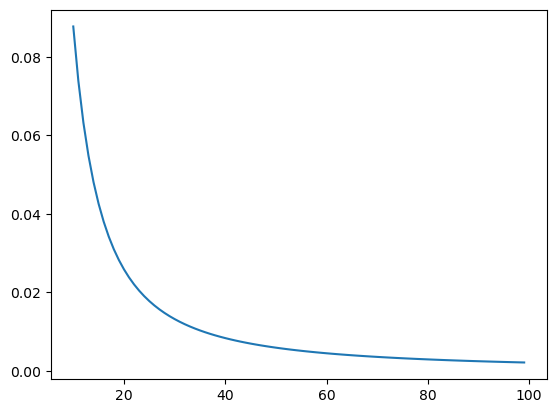

In [3]:
# training with QEM-ZMSEPC method

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
p = 0.9

qemzmsepc = qem.QEMZMSEPC(n_qubits)

def train_cir_with_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    z_miti, _ = qemzmsepc.qemzmsepc(train_cir_with_qem, p, dev, x,
            kraus_matrices_of_a_pauli_channel=nqubitspaulichannel)
    return (z_miti - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()